### Develop notebook

**Todos**

- [x] Sanity check implementation of IPD where agent two sees the actions of agent one
- [ ] Test functions and visualize Q-value trajectories

In [6]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Tuple, Union
from gym import Space, spaces
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from prisoners_dilemma import utils
from prisoners_dilemma.env import PrisonersDilemmaEnv

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (7, 4)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Setup config
config = {
    'num_simuls': 1,
    'num_episodes': 500,
    'num_agents': 2,
    'num_actions': 2,
    'verbose': False,
    'init_type':'zeros',
}

config['payoffs'] = {
    'reward_payoff': 2,
    'tempta_payoff': 3,
    'sucker_payoff': 0,
    'punish_payoff': 1,
}

config['params'] = {
    'alpha': np.array([0.1, 0.1]),
    'eps': np.array([0.2, 0.2]),
    'gamma': np.array([0.5, 0.5]),
}


q_traj_one, q_traj_two, rewards_seq, actions_seq = utils.run_extended_ipd_exp(config)

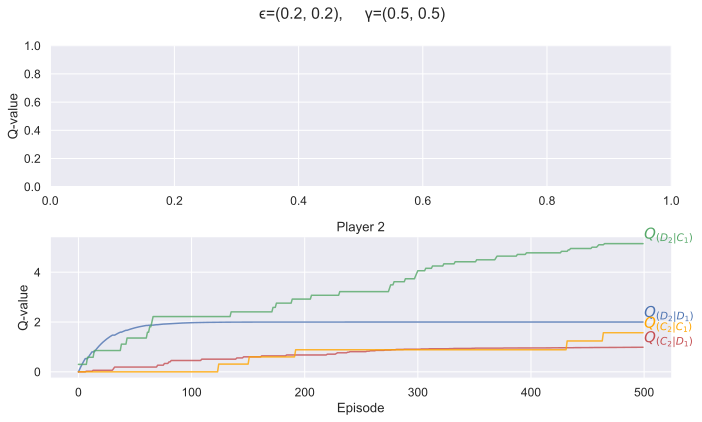

In [18]:
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 6)})

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})
fig.suptitle(
    f'ϵ=({config["params"]["eps"][0]}, {config["params"]["eps"][1]}), \
    γ=({config["params"]["gamma"][0]}, {config["params"]["gamma"][1]})')

# Agent one (who doesn't have observations)
axs[0].set_title('Player 1')
agent_one_labels = ['$Q_{(D_1 | D_2)}$', '$Q_{(D_1 | C_2)}$', '$Q_{(C_1 | D_2)}$', '$Q_{(C_1 | C_2)}$',]
agent_one_colors = ['b', 'g', 'r', 'orange']
idx = 0
for action_i in range(config['num_actions']):
    for cond_act_i in range(config['num_actions']):
        axs[0].plot(
            q_traj_one[:, action_i, cond_act_i],
            color=agent_one_colors[idx], alpha=.8
        )
        axs[0].text(
            q_traj_one.shape[0],
            q_traj_one[-1, action_i, cond_act_i],
            agent_one_labels[idx],
            color=agent_one_colors[idx],
            fontsize=15,
            weight='bold',
            va='bottom',
        )
        idx += 1
    
axs[1].set_title('Player 2')
agent_one_labels = ['$Q_{(D_2 | D_1)}$', '$Q_{(D_2 | C_1)}$', '$Q_{(C_2 | D_1)}$', '$Q_{(C_2 | C_1)}$',]
agent_one_colors = ['b', 'g', 'r', 'orange']
idx = 0
for action_i in range(config['num_actions']):
    for cond_act_i in range(config['num_actions']):
        axs[1].plot(
            q_traj_two[:, action_i, cond_act_i],
            color=agent_one_colors[idx], alpha=.8
        )
        axs[1].text(
            q_traj_two.shape[0],
            q_traj_two[-1, action_i, cond_act_i],
            agent_one_labels[idx],
            color=agent_one_colors[idx],
            fontsize=15,
            weight='bold',
            va='bottom',
        )
        idx += 1

axs[0].set_ylabel('Q-value')
axs[1].set_ylabel('Q-value')
axs[1].set_xlabel('Episode')
sns.despine()
plt.tight_layout()